In [7]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [2]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [3]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [8]:
labels = pd.read_csv("./train-data-1/labels/enif_ob1_train_labels.csv")

In [9]:
labels

,sample_name,x_axis_min,x_axis_max,x_axis_ticks,y_axis_min,y_axis_max,y_axis_ticks
0,20220810134652550053.png,-727.25,-567.75,[-727.25 -707.3125 -687.375 -667.4375 -647....,-164.85,95.85,[-164.85 -127.60714286 -90.36428571 -5...
1,20220810134519045308.png,-795.85,-7.15,[-795 -683 -570 -457 -345 -232 -119 -7],-460.15,269.15,[-460 -338 -217 -95 26 147 269]
2,20220810134638151195.png,-118.35,835.35,[-118.35 17.89285714 154.13571429 29...,-138.35,155.35,[-138.35 -101.6375 -64.925 -28.2125 8....
3,20220810134456589511.png,-286.55,319.55,[-286.55 -165.33 -44.11 77.11 198.33 319.55],-250.00,190.00,[-250. -140. -30. 80. 190.]
4,20220810134619811928.png,-394.30,404.30,[-394.3 -261.2 -128.1 5. 138.1 271.2 40...,-304.50,432.50,[-304.5 -199.21428571 -93.92857143 1...
...,...,...,...,...,...,...,...
495,20220810135022903656.png,-35.35,808.35,[-35.35 175.575 386.5 597.425 808.35 ],-63.70,-26.30,[-63.7 -59.025 -54.35 -49.675 -45. -40.3...
496,20220810134023205567.png,287.80,952.20,[287.8 370.85 453.9 536.95 620. 703.05 786...,-70.50,-37.50,[-70.5 -59.5 -48.5 -37.5]
497,20220810134016605767.png,-865.25,-463.75,[-865 -731 -597 -463],-502.00,334.00,[-502 -293 -84 124 333]
498,20220810134753572071.png,-141.05,344.05,[-141 20 182 344],-516.50,-21.50,[-516 -434 -351 -269 -186 -104 -21]


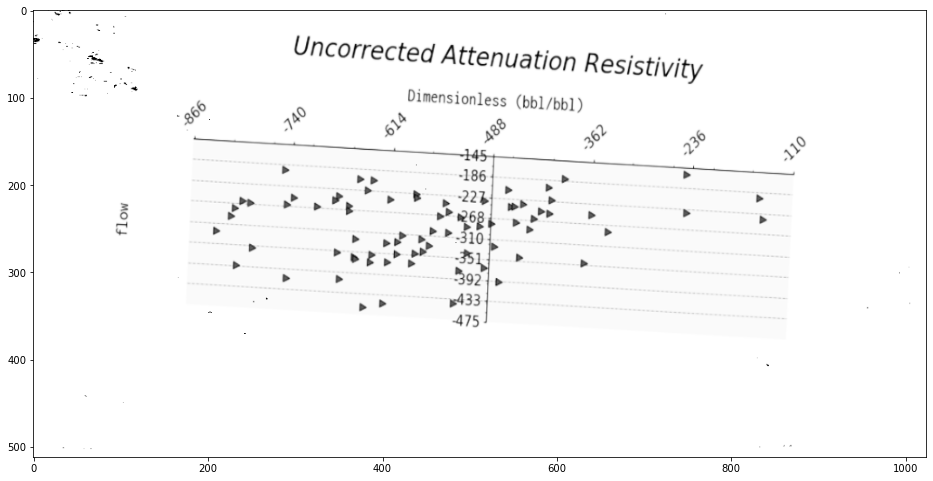

In [11]:
file_name = "./train-data-1/images/20220810133918465374.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

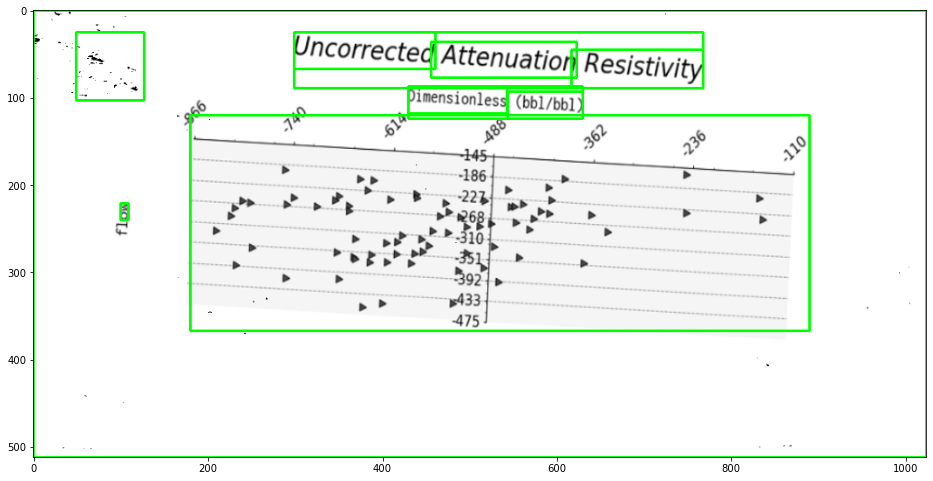

In [12]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [13]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

Uncorrected Attenuation Resistivity

Dimensionless (bb1/bb1)

 

g

 



In [17]:
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt

In [19]:
#Creating argument dictionary for the default arguments needed in the code. 
args = {"image": file_name, 
        "east":"./train-data-1/frozen_east_text_detection.pb", 
        "min_confidence":0.5, 
        "width":320, 
        "height":320}

In [20]:
#Give location of the image to be read.
#"Example-images/ex24.jpg" image is being loaded here. 

args['image'] = file_name
image = cv2.imread(args['image'])

#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [21]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet(args["east"])

# We would like to get two outputs from the EAST model. 
#1. Probabilty scores for the region whether that contains text or not. 
#2. Geometry of the text -- Coordinates of the bounding box detecting a text
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [22]:
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

In [24]:
## Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [25]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [70]:
##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 1")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))

In [69]:
results

[((278, 32, 464, 62), 'Uncorrected\n\x0c'),
 ((614, 52, 764, 80), '? ReSIstivity\n\x0c'),
 ((409, 92, 540, 113), 'Dimensionless\n\x0c'),
 ((467, 41, 617, 72), 'Attenuatior\n\x0c'),
 ((553, 96, 646, 118), '\x0c')]

Uncorrected


? ReSIstivity


Dimensionless


Attenuatior






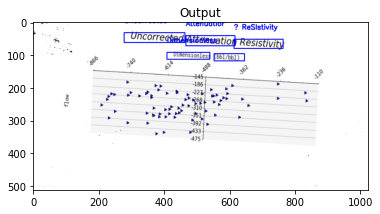

In [34]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()